Mounted at /content/drive
unit_number
1    192
2    287
3    179
4    189
5    269
Name: time_in_cycles, dtype: int64
   unit_number  time_in_cycles  op_setting_1  op_setting_2  \
0            1               1       -0.0007       -0.0004   
1            1               2        0.0019       -0.0003   
2            1               3       -0.0043        0.0003   
3            1               4        0.0007        0.0000   
4            1               5       -0.0019       -0.0002   

   sensor_measurement_2  sensor_measurement_3  sensor_measurement_4  \
0                641.82               1589.70               1400.60   
1                642.15               1591.82               1403.14   
2                642.35               1587.99               1404.20   
3                642.35               1582.79               1401.87   
4                642.37               1582.85               1406.22   

   sensor_measurement_6  sensor_measurement_7  sensor_measurement_8  \
0          

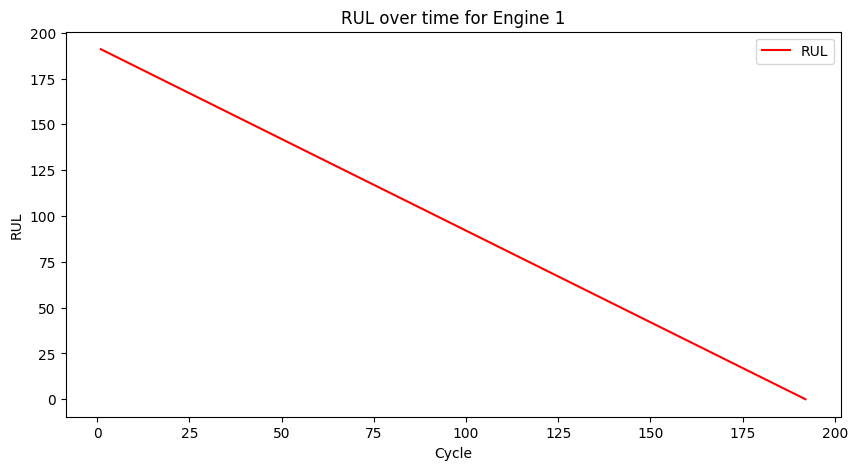

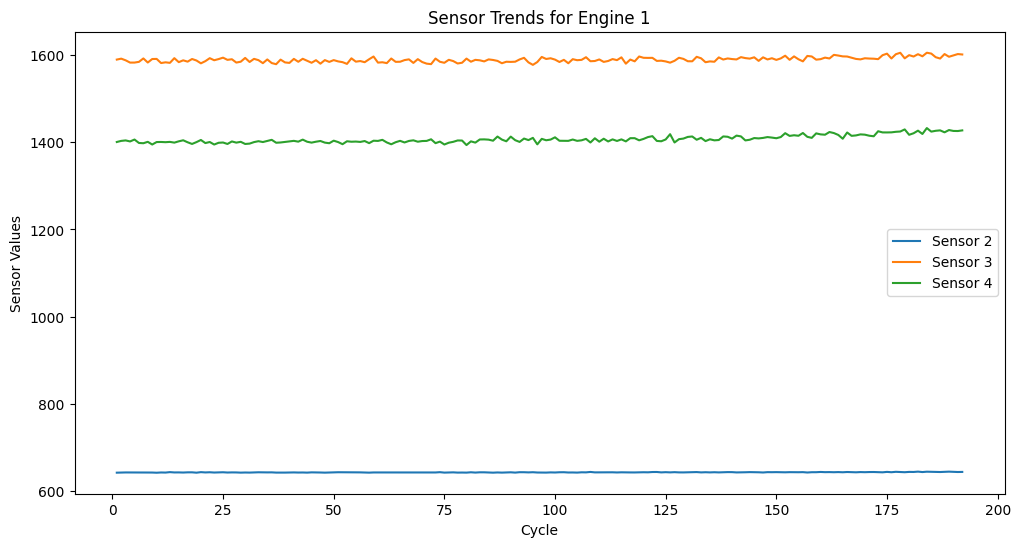

   unit_number  time_in_cycles  RUL
0            1               1  191
1            1               2  190
2            1               3  189
3            1               4  188
4            1               5  187

Correlation of sensors with RUL:
sensor_measurement_11   -0.696228
sensor_measurement_4    -0.678948
sensor_measurement_12    0.671983
sensor_measurement_7     0.657223
sensor_measurement_15   -0.642667
sensor_measurement_21    0.635662
sensor_measurement_20    0.629428
sensor_measurement_2    -0.606484
sensor_measurement_17   -0.606154
sensor_measurement_3    -0.584520
sensor_measurement_8    -0.563968
sensor_measurement_13   -0.562569
sensor_measurement_9    -0.390102
sensor_measurement_6    -0.128348
Name: RUL, dtype: float64


/tmp/ipython-input-4105738988.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rul_corr.values , y = rul_corr.index , palette = "coolwarm")


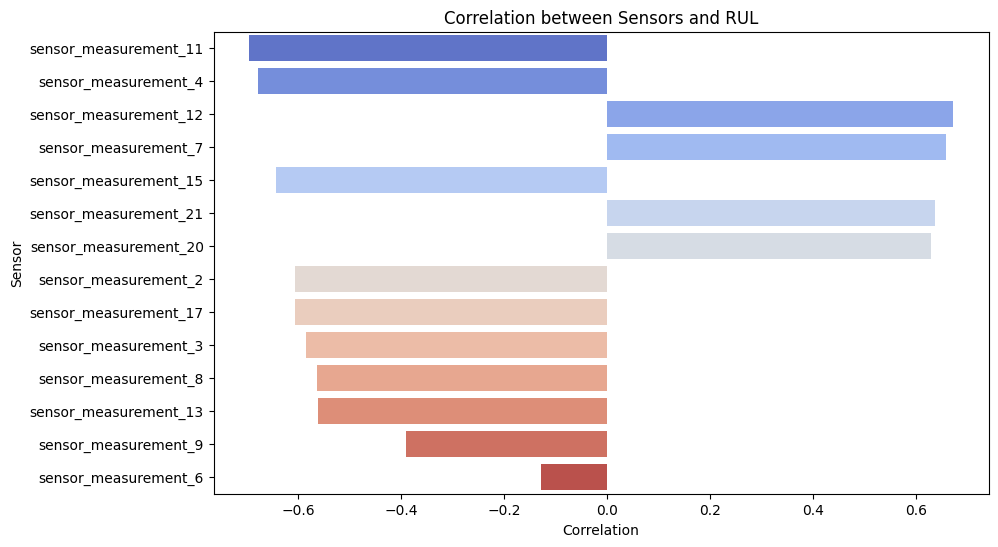

Dropping low correlation sensors: ['sensor_measurement_6']

Final features selected: ['op_setting_1', 'op_setting_2', 'sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_15', 'sensor_measurement_17', 'sensor_measurement_20', 'sensor_measurement_21']
features shape: (20631, 15)
Target shape: (20631,)

Missing values Found:
Series([], dtype: int64)
sensor_measurement_2 outliers count: 128

Outlier counts per sensor:
{'sensor_measurement_2': np.int64(128), 'sensor_measurement_3': np.int64(165), 'sensor_measurement_4': np.int64(120), 'sensor_measurement_7': np.int64(110), 'sensor_measurement_8': np.int64(320), 'sensor_measurement_9': np.int64(1686), 'sensor_measurement_11': np.int64(167), 'sensor_measurement_12': np.int64(146), 'sensor_measurement_13': np.int64(161), 'sensor_measurement_15': np.int64(120),

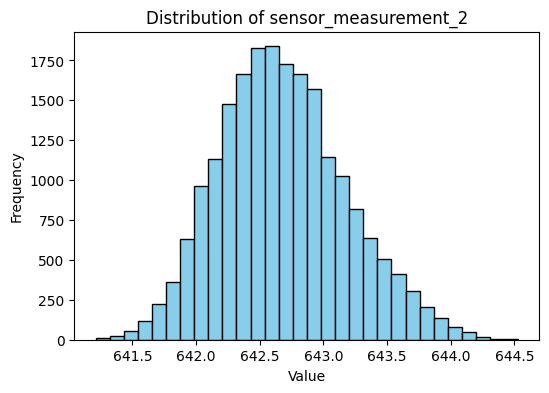

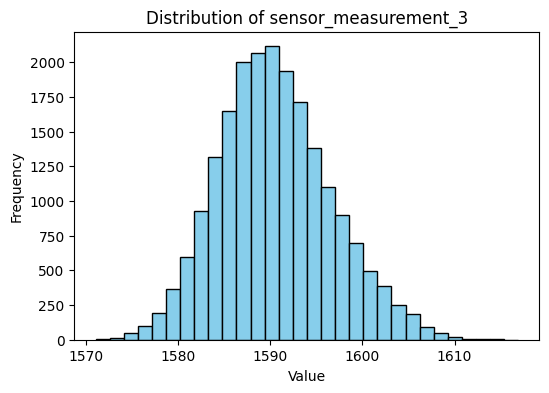

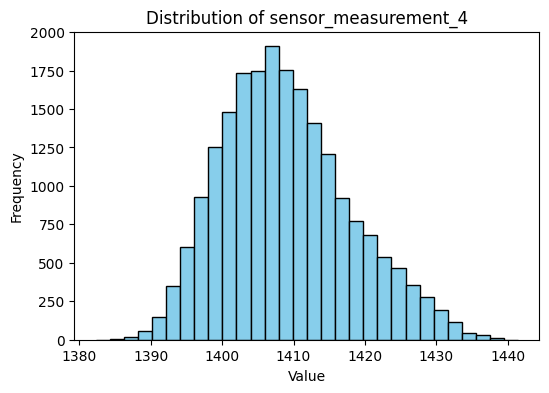

/tmp/ipython-input-4105738988.py:208: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby("unit_number", group_keys=False).apply(lambda g: g.iloc[2:]).reset_index(drop=True)



Preview with rolling features:
    unit_number  time_in_cycles  op_setting_1  op_setting_2  \
0             1               3       -0.0043        0.0003   
1             1               4        0.0007        0.0000   
2             1               5       -0.0019       -0.0002   
3             1               6       -0.0043       -0.0001   
4             1               7        0.0010        0.0001   
5             1               8       -0.0034        0.0003   
6             1               9        0.0008        0.0001   
7             1              10       -0.0033        0.0001   
8             1              11        0.0018       -0.0003   
9             1              12        0.0016        0.0002   
10            1              13       -0.0019        0.0004   
11            1              14        0.0009       -0.0000   
12            1              15       -0.0018       -0.0003   
13            1              16        0.0006        0.0005   
14            1        

In [ ]:
### ------------------------------------------------------------------------- ###
# --- Feature Engineering & Data Quality
### ------------------------------------------------------------------------- ###

# --- 1. Imports ---
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Creating a path for plots to be saved in PNG form
if not os.path.exists('../results'):
    os.makedirs('../results')
# --- 2. Mount Google Drive & Load Dataset ---
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/predictive_maintenance/cleaned_train_FD001.csv'  # we have to load dataset saved in previous code from drive
train_df = pd.read_csv(file_path)


# ----------------------------------- #
# --- 3. Remaining Uselful Life (RUL)
# ----------------------------------- #

# Find maximum cycles per engine
max_cycles = train_df.groupby('unit_number')['time_in_cycles'].max()
print(max_cycles.head())   # This gives a series where each unit_number has its final cycle count

# To Map RUL to each row --> RUL = max_cycles_for_that_engine - current_cycle
train_df['max_cycle'] = train_df['unit_number'].map(max_cycles)
train_df['RUL'] = train_df['max_cycle'] - train_df['time_in_cycles']  # Now we have an RUL column

# Dropping helper column --> max_cycle was just for calculation, we don't need it anymore
train_df.drop(columns = ['max_cycle'], inplace = True)
print(train_df.head())   # RUL column for each row

print("\nPreview with RUL:")
print(train_df[['unit_number', 'time_in_cycles', 'RUL']].head(10)) # The RUL counting down from the start to zero for each engine

# Shows first 50 rows with RUL and some sensors
print(train_df[['RUL' , 'sensor_measurement_2' , 'sensor_measurement_3' , 'sensor_measurement_4']].head(50))

# ------------------------------------------- #
# --- 4. binary Classification Label --- --> To identify or predict if the machine is going to fail after threold limit we set or if RUL <= thresold then engine needs attention soon.

# Choose thresold
thresold = 30

# Create binary label
train_df['label1'] = np.where(train_df['RUL'] <= thresold ,1, 0)

# Checking few rows
print("\nBinary Classification preview:")
print(train_df[['unit_number' , 'time_in_cycles' , 'RUL' , 'label1']].head(50))

# ------------------------------------------- #
# --- 5. Visualization - Example Engine  (let us take analysis of one engine) ---
# ------------------------------------------- #

# Filter for one engine
unit_1 = train_df[train_df['unit_number'] == 1]

# Plot RUL over time
plt.figure(figsize=(10, 5))
plt.plot(unit_1['time_in_cycles'], unit_1['RUL'], label='RUL', color='red')
plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.title('RUL over time for Engine 1')
plt.legend()
plt.show()

# Plot of sensor measurements over time
plt.figure(figsize=(12, 6))
plt.plot(unit_1['time_in_cycles'], unit_1['sensor_measurement_2'], label='Sensor 2')
plt.plot(unit_1['time_in_cycles'], unit_1['sensor_measurement_3'], label='Sensor 3')
plt.plot(unit_1['time_in_cycles'], unit_1['sensor_measurement_4'], label='Sensor 4')
plt.xlabel('Cycle')
plt.ylabel('Sensor Values')
plt.title('Sensor Trends for Engine 1')
plt.legend()
plt.show()

# --------------------------------------------- #
# --- 6. Check correlations between RUL & sensors (result suggests to drop sensors which are not highly correlated with RUL)
# --------------------------------------------- #

# let Compute RUL
rul_df = train_df.groupby('unit_number')['time_in_cycles'].max().reset_index()  # Find last cycle for each engine
rul_df.columns = ['unit_number' , 'max_cycle']  # time_in_cycles renamed to max_cycle coz it's the last cycle for that engine

# Merge RUL into training data
train_df = train_df.merge(rul_df, on ='unit_number' , how = 'left')
train_df['RUL'] = train_df['max_cycle'] - train_df['time_in_cycles']

# Clean up - Drop max_cycle as it's no longer needed
train_df = train_df.drop(columns = ['max_cycle'])
print(train_df[['unit_number' , 'time_in_cycles' , 'RUL']].head())

# Get/Select only sensor columns
sensor_cols = [col for col in train_df.columns if 'sensor_measurement' in col]

# Compute correlations
rul_corr = train_df[sensor_cols + ['RUL']].corr()['RUL'].drop('RUL').sort_values(key=abs, ascending=False)
print("\nCorrelation of sensors with RUL:")
print(rul_corr)

# Visualizing correlations
plt.figure (figsize=(10,6))
sns.barplot(x=rul_corr.values , y = rul_corr.index , palette = "coolwarm")
plt.title("Correlation between Sensors and RUL")
plt.xlabel("Correlation")
plt.ylabel("Sensor")
plt.show()

# Now Dropping useless sensors or the sensors that are least useful  (example: abs(corr) < 0.2) (the relation value can vary )
low_corr_sensors = rul_corr[abs(rul_corr) < 0.2].index
print("Dropping low correlation sensors:" , list(low_corr_sensors))
train_df = train_df.drop(columns = low_corr_sensors)

# also Defined the final features list based on the current dataframe
final_features = [col for col in train_df.columns
                  if 'sensor_measurement' in col or 'op_setting' in col]

print("\nFinal features selected:", final_features)

# --------------------------------------------------- #
# ---7. Define Final training set ---
# --------------------------------------------------- #

X = train_df[final_features]
y = train_df['RUL']
print("features shape:" , X.shape)
print("Target shape:" , y.shape)

# ---------------------------------------------------- #
# ---------------------------------------------------- #

# Checking for any missing values  --> shows we can clean real_world messy data.
missing_counts = train_df.isnull().sum()
print("\nMissing values Found:")
print(missing_counts[missing_counts > 0])

# If there are missing values, handle them:
# Option 1: Fill with mean
# train_df.fillna(train_df.mean(), inplace=True)

# Check for outliers (outliers can cause noise in your model) --> shows we think critically about data quality.
# Example: detect outliers in one sensor

sensor = 'sensor_measurement_2'
Q1 = train_df[sensor].quantile(0.25)
Q3 = train_df[sensor].quantile(0.75)
IQR = Q3 - Q1

outliers = train_df[(train_df[sensor] <  Q1 - 1.5 * IQR) | (train_df[sensor] > Q3 + 1.5 * IQR)]
print(f"{sensor} outliers count:" , outliers.shape[0])

# loop all ovr sensors
outlier_counts = {}
for col in [c for c in train_df.columns if'sensor_measurement' in c]:
  Q1 = train_df[col].quantile(0.25)
  Q3 = train_df[col].quantile(0.75)
  IQR = Q3 - Q1
  outlier_counts[col] = ((train_df[col] < Q1 - 1.5 * IQR) | (train_df[col] > Q3 + 1.5 * IQR)).sum()

print("\nOutlier counts per sensor:")
print(outlier_counts)      # We won't remove them blindly --> just note which sensors have extrmr values.

# Distribution of key sensors
# Plot histogram of key sensors

key_sensors = ['sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4']
for col in key_sensors:
  plt.figure(figsize=(6, 4))
  plt.hist(train_df[col], bins=30, color='skyblue', edgecolor='black')
  plt.title(f'Distribution of {col}')
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  plt.show()

# ---------------------------------------- #
# --- 8. Feature Engineering - Rolling Stats ---
# ----------------------------------------- #
# Choos rolling window size
window_size = 5

# Get only sensor columns
sensor_cols = [col for col in train_df.columns if 'sensor_measurement' in col]

# For each sensor, calculate rolling mean & std for each engine separately
for sensor in sensor_cols :
  train_df[f"{sensor}_rolling_mean"] =(
      train_df.groupby('unit_number')[sensor]
      .rolling(window_size, min_periods = 1)   #allow smaller windows at start
      .mean()
      .reset_index(level=0,drop = True )
)
  train_df[f"{sensor}_rolling_std"] =(
      train_df.groupby('unit_number')[sensor]
      .rolling(window_size, min_periods = 1)   #allow smaller windows at start
      .std()
      .reset_index(level=0,drop = True )
)
# drop first (window-1) rows per unit to avoid NaN in rolling features
train_df = train_df.groupby("unit_number", group_keys=False).apply(lambda g: g.iloc[2:]).reset_index(drop=True)
print("\nPreview with rolling features:")
print(train_df.head(15))

# ------------------------------------------ #
# ---9. Save processed todya's dataset
# ------------------------------------------ #
output_path = "/content/drive/MyDrive/predictive_maintenance/processed_train_FD001.csv"
train_df.to_csv(output_path, index=False)
print(f"Processed dataset saved to: {output_path}")


# ========================================================== #
# Summary

# With this code and dataset, one can Compute Remaining Useful Life (RUL)
# Binary Classification Level helps in converting RUL into a yes/no signal for imminent failure.
# Visualization is optional for this project but it helps understand how sensore behave over time (better to understand through plots instead of predicting from only values printed)
# Outlier detection & distribution Analysis

# ========================================================== #